<div style="background-color:#004D40; padding:25px; border-radius:12px">
  <h1 style="color:#FFEB3B; text-align:center; font-size:42px; margin:0;">
    DÉTECTION AUTOMATISÉE DES FAUX BILLETS
  </h1>
</div>

<div style="text-align:center; margin-top:10px;">
  <p style="font-size:18px; text-align:center; font-weight:bold; color:white;">
    Mission confiée par l’ONCFM – Organisation Nationale de Lutte contre le Faux-Monnayage
  </p>
</div>


<div style="background-color:#1976D2; padding:10px; border-radius:8px">
  <h2 style="color:white; text-align:center;"> Notebook 1 – Analyse exploratoire, traitement des données et modélisation</h2>
</div>

<p style="text-align:center; font-size:15px">
Ce notebook contient l'exploration des données géométriques des billets, les traitements préalables, les tests de modèles de machine learning et la sélection du meilleur algorithme.
</p>


<div style="background-color:#1A237E; padding:18px; border-radius:10px; margin-top:20px;">
  <h2 style="color:white; text-align:center; font-size:30px; margin:0;">
     Étape 1 – Chargement et visualisation initiale des données
  </h2>
</div>


In [4]:
#  Importation des bibliothèques nécessaires

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


In [5]:
#  Chargement du fichier billets.csv
df = pd.read_csv("billets.csv", sep=';')


In [6]:
#  Aperçu des 5 premières lignes du jeu de données

df.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [7]:
# Informations sur les colonnes et types de données

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


<div style="background-color:#283593; padding:18px; border-radius:10px; margin-top:20px;">
  <h2 style="color:white; text-align:center; font-size:30px; margin:0;">
     Étape 2 – Analyse exploratoire des données
  </h2>
</div>


In [9]:
# Statistiques descriptives générales

df.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

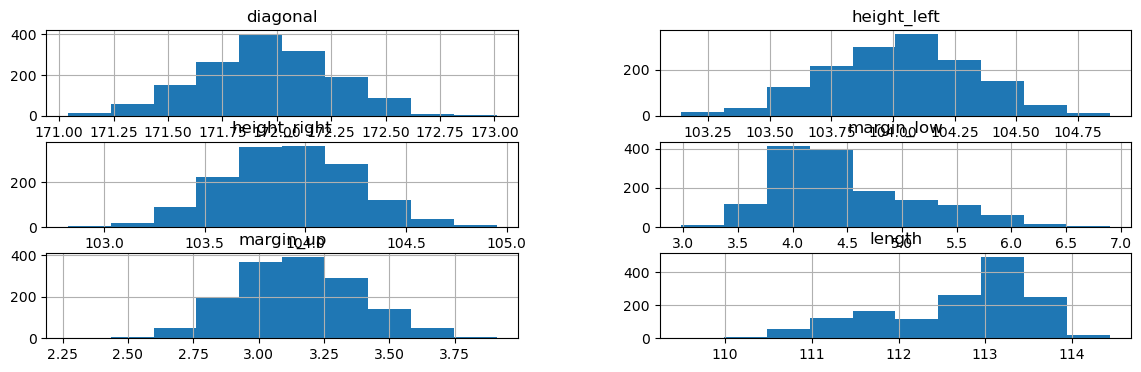

In [10]:
# histogramme pour chaque variable numérique

df.drop(columns="is_genuine").hist(figsize=(14, 4))
plt.show()

In [11]:
# variables propres et bien distribuées (diagonal, height_left, height_right)
# variables plus dispersées qui pourraient aider à distinguer vrais/faux billets (margin_low, length),
# une variable à traiter en priorité pour les valeurs manquantes : margin_low

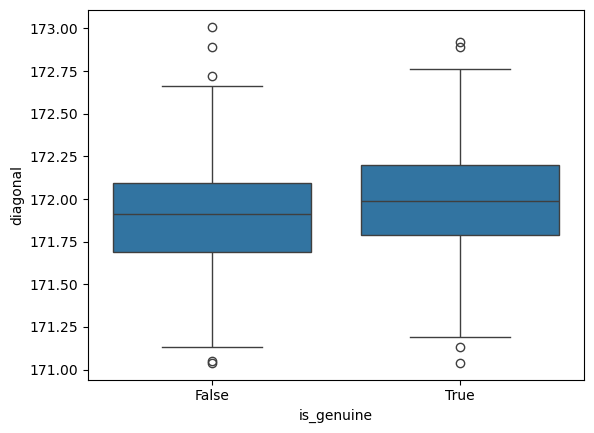

In [12]:
#  Comparer les valeurs par variable entre vrais et faux billets

sns.boxplot(data=df, x='is_genuine', y='diagonal')
plt.show()

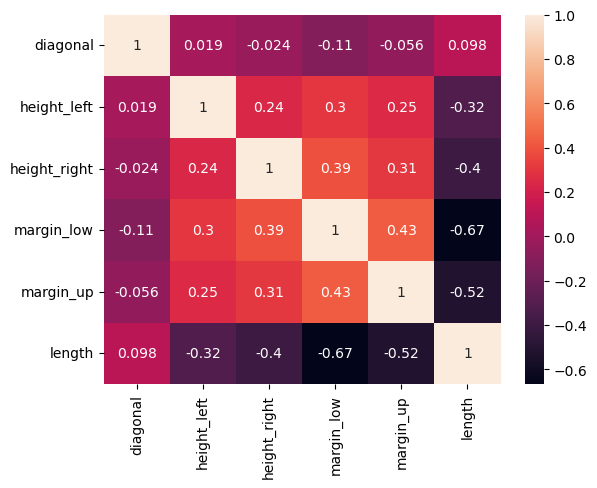

In [13]:
# la corrélation entre les variables

sns.heatmap(df.drop(columns='is_genuine').corr(), annot=True)
plt.show()

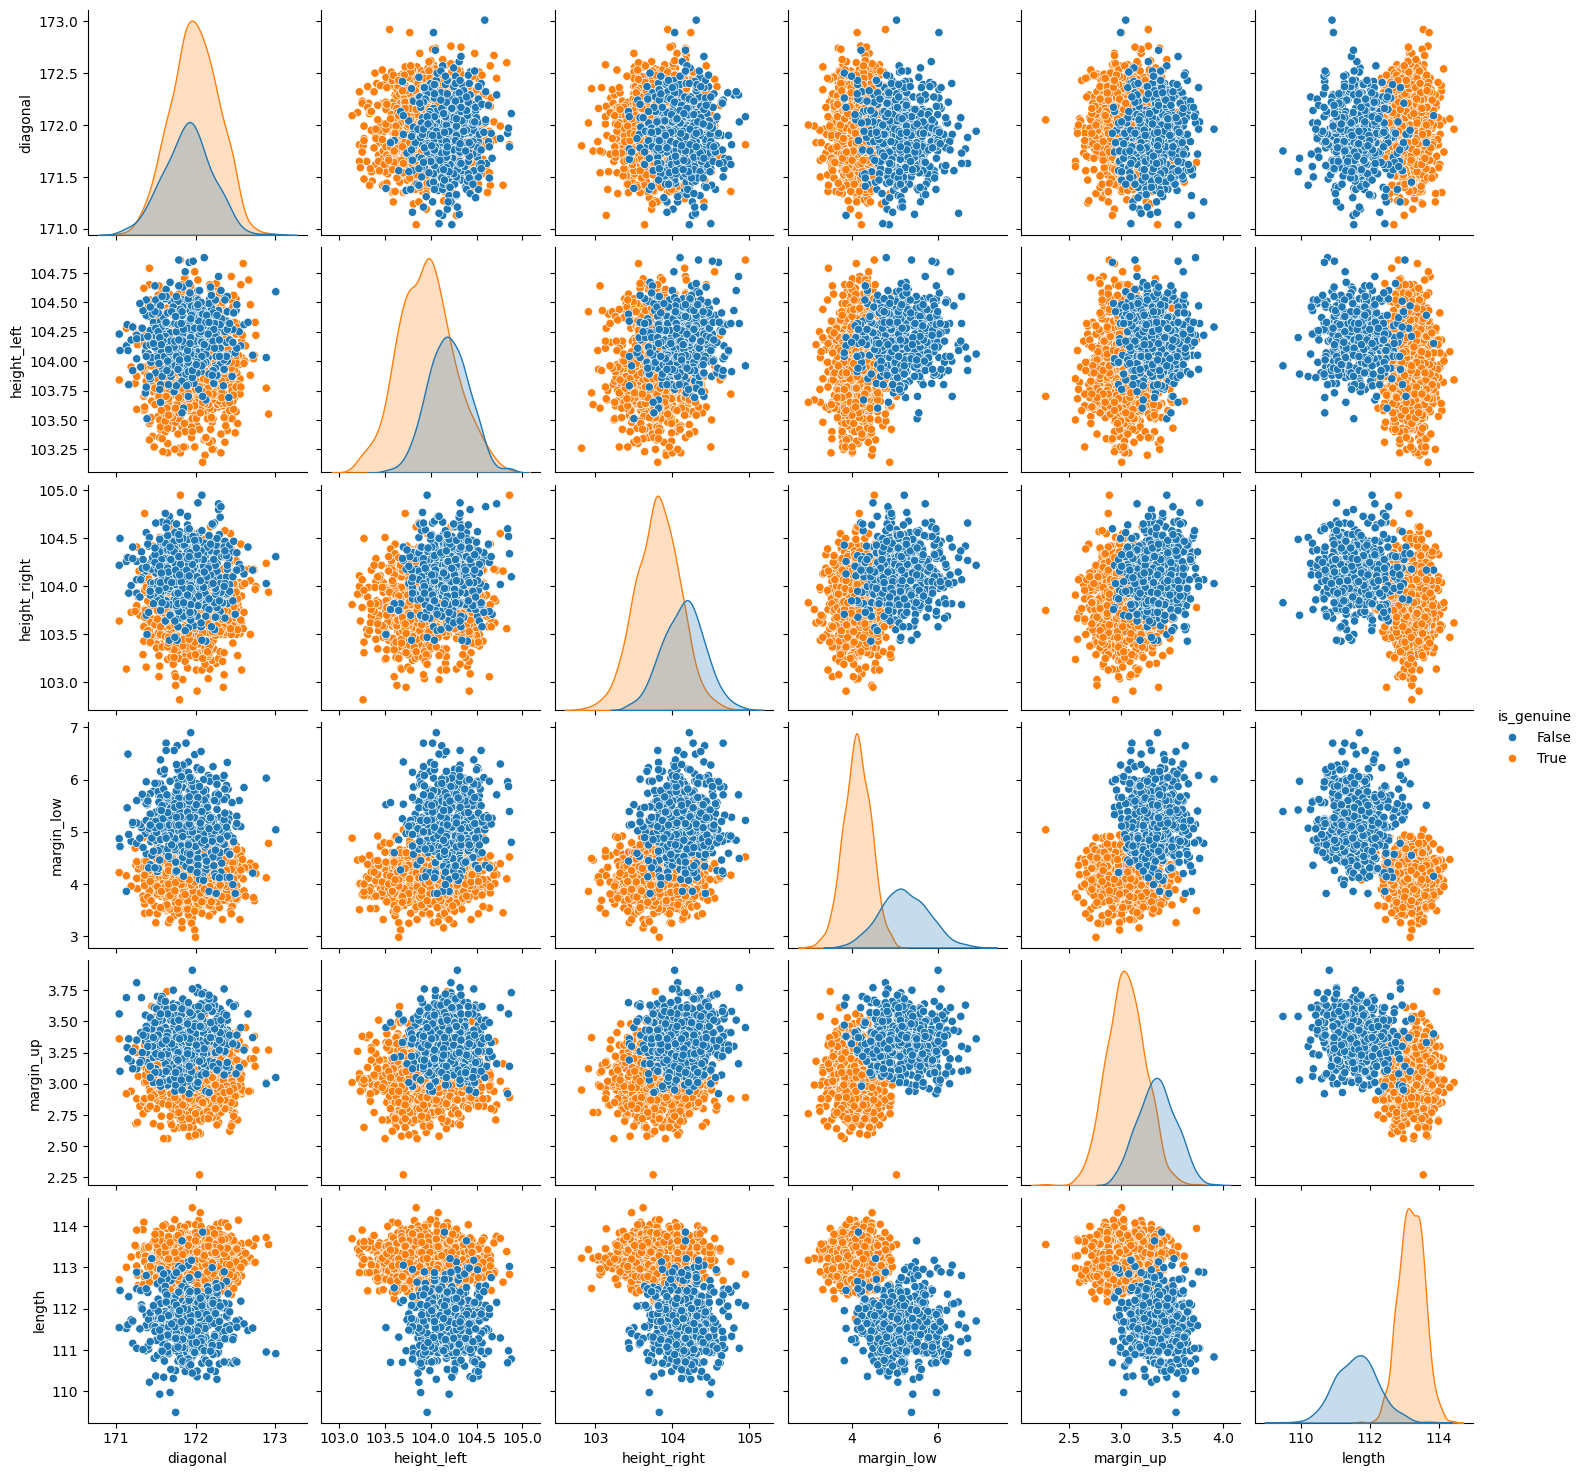

In [14]:
# Visualisation croisée des variables en couleur selon billet vrai/faux

sns.pairplot(df, hue='is_genuine')

In [15]:
# margin_low-----> Séparation très nette entre vrais et faux billets.
# length----->Très bon critère : les vrais billets ont souvent une longueur plus élevée.
# margin_up------>Bonne séparation aussi, mais moins nette que les deux précédentes.

# height_left----->Nuages très superposés
# height_right----->Beaucoup de chevauchement
# diagonal------>Légère différence, mais pas suffisant seul

<div style="background-color:#2E7D32; padding:18px; border-radius:10px; margin-top:20px;">
  <h2 style="color:white; text-align:center; font-size:30px; margin:0;">
     Étape 3 – Prédiction des valeurs manquantes avec régression linéaire
  </h2>
</div>


In [17]:
# But : prédire les valeurs manquantes de la colonne margin_low à l’aide d’un modèle entraîné sur les lignes complètes, en utilisant 
# des variables corrélées.

In [18]:
# 1. Séparer les lignes avec et sans valeur manquante dans margin_low
df_complet = df[df['margin_low'].notna()]
df_manquant = df[df['margin_low'].isna()]

#  2. Choix des variables explicatives (celles qui sont les plus corrélées à margin_low)
colonnes_pred = ['length', 'margin_up', 'height_right', 'height_left']

# 3. Création du modèle de régression linéaire
model = LinearRegression()

# Entraînement sur les lignes complètes
X_train = df_complet[colonnes_pred]
y_train = df_complet['margin_low']
model.fit(X_train, y_train)

# 4. Prédiction des valeurs manquantes
X_missing = df_manquant[colonnes_pred]
y_pred = model.predict(X_missing)

# 5. Remplacement des NaN par les valeurs prédites
df.loc[df['margin_low'].isna(), 'margin_low'] = y_pred


In [19]:
df['margin_low'].isna().sum()

0

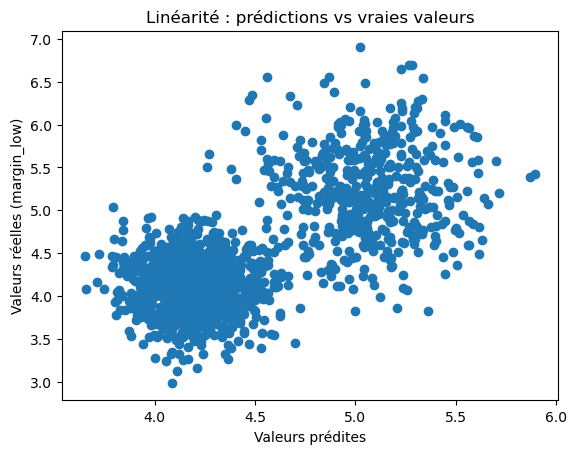

In [20]:
#  la relation linéaire entre valeurs prédites et réelles

y_pred_train = model.predict(X_train)

plt.scatter(y_pred_train, y_train)
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles (margin_low)")
plt.title("Linéarité : prédictions vs vraies valeurs")
plt.show()


In [21]:
# les points suivent une diagonale, et sont globalement alignés par nuages compacts ➜ bonne linéarité

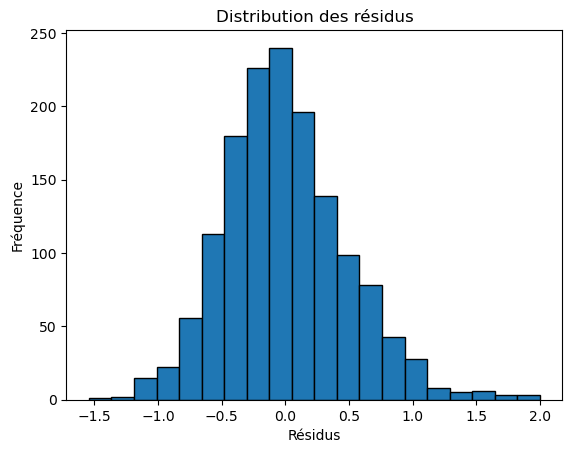

In [22]:
# Histogramme des résidus

residus = y_train - y_pred_train

plt.hist(residus, bins=20, edgecolor='black')
plt.title("Distribution des résidus")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.show()


In [23]:
# la forme est en cloche ➜ les résidus sont normalement distribués.

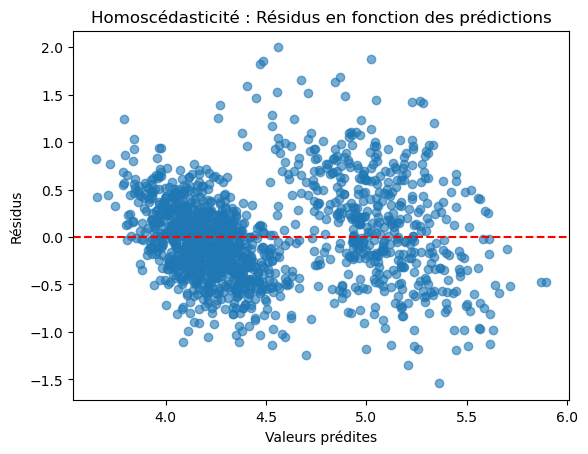

In [24]:
# Homoscédasticité : résidus vs valeurs prédites

plt.scatter(y_pred_train, residus, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Homoscédasticité : Résidus en fonction des prédictions")
plt.show()


In [25]:
# les points sont répartis de façon aléatoire autour de 0 sans motif clair ni entonnoir➜ bonne homoscédasticité

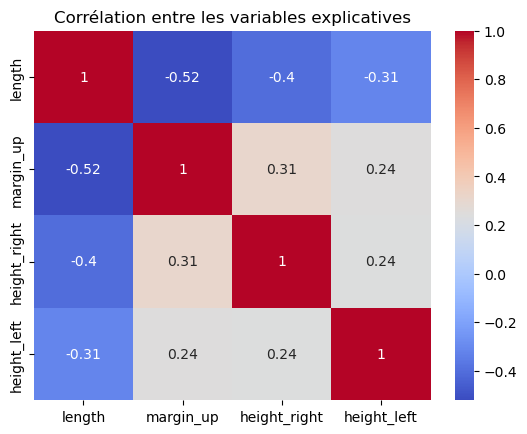

In [26]:
# Corrélation entre variables explicatives

sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation entre les variables explicatives")
plt.show()


In [27]:
# Les plus fortes corrélations sont autour de 0.52, 0.4, 0.31, donc bien en-dessous du seuil critique.
# donc la condition d'absence de colinéarité forte est respectée

In [28]:
# la proportion de la variance de la variable cible 

r2 = model.score(X_train, y_train)
print("R² :", r2)

R² : 0.4747600714833762


In [29]:
# Le R² de 0,47 montre que le modèle explique environ la moitié de la variance de margin_low, ce qui 
# est suffisant pour une tâche d’imputation. D’autant plus que toutes les hypothèses de
# validité sont respectées (linéarité, normalité, homoscédasticité, absence de colinéarité)

<div style="background-color:#1565C0; padding:18px; border-radius:10px; margin-top:20px;">
  <h2 style="color:white; text-align:center; font-size:30px; margin:0;">
     Étape 4 – Nettoyage et préparation des données
  </h2>
</div>


In [31]:
# Suppression des doublons éventuels dans le DataFrame
df = df.drop_duplicates()


In [32]:
# Vérification de la variable cible 
df['is_genuine'].unique()


array([ True, False])

In [33]:
# Définition des features (X) et de la cible (y)
X = df.drop(columns='is_genuine')   # toutes les colonnes sauf la cible
y = df['is_genuine'].astype(int)    # on convertit True/False en 1/0


In [34]:
# Standardisation des variables (moyenne 0, écart-type 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
# Séparation du jeu de données (80 % train / 20 % test)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

<div style="background-color:#880E4F; padding:18px; border-radius:10px; margin-top:20px;">
  <h2 style="color:white; text-align:center; font-size:30px; margin:0;">
    5. Modélisation – Test des 4 algorithmes
  </h2>
</div>


<div style="background-color:#AD1457; padding:15px; border-radius:10px; margin-top:20px;">
  <h3 style="color:white; text-align:center; font-size:26px; margin:0;">
    5.1 – Régression logistique
  </h3>
</div>


In [38]:
# instance du modèle
logreg = LogisticRegression()

# Entraînement sur les données d'apprentissage
logreg.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred_logreg = logreg.predict(X_test)

# Taux de bonne classification (accuracy)
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy :", round(accuracy, 3))

# Matrice de confusion
print("\n Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_logreg))

# Rapport complet : précision, rappel, f1-score
print("\n Rapport de classification :")
print(classification_report(y_test, y_pred_logreg))


Accuracy : 0.993

 Matrice de confusion :
[[108   2]
 [  0 190]]

 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       110
           1       0.99      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [39]:
# Le modèle a correctement classé 99,3 % des billets sur le jeu de test

# 108 vrais négatifs (faux billets bien identifiés)
# 190 vrais positifs (vrais billets bien identifiés)
# 2 faux positifs (vrais billets classés à tort comme faux)
# 0 faux négatif (aucun faux billet manqué !)

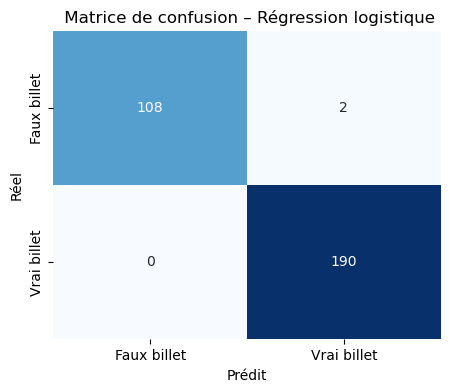

In [40]:
# Affichage graphique de la matrice de confusion

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_logreg)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Faux billet", "Vrai billet"],
            yticklabels=["Faux billet", "Vrai billet"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title(" Matrice de confusion – Régression logistique")
plt.show()


<div style="background-color:#6A1B9A; padding:15px; border-radius:10px; margin-top:20px;">
  <h3 style="color:white; text-align:center; font-size:26px; margin:0;">
    5.2 – K-means (non supervisé)
  </h3>
</div>


In [42]:
# Initialisation avec 2 clusters (vrai/faux)
kmeans = KMeans(n_clusters=2, random_state=42)

# Entraînement sur les variables explicatives standardisées
kmeans.fit(X_scaled)

# Prédiction des clusters
cluster_labels = kmeans.labels_


In [43]:
# Évaluer la correspondance entre clusters et vraies classes

# Calcul de la matrice de confusion
cm_kmeans = confusion_matrix(y, cluster_labels)

# Affichage de la matrice
print("Matrice de confusion K-means :\n", cm_kmeans)

# Comme les étiquettes peuvent être inversées, on ajuste si besoin
accuracy1 = accuracy_score(y, cluster_labels)
accuracy2 = accuracy_score(y, 1 - cluster_labels)

print("Accuracy K-means (option 1) :", accuracy1)
print("Accuracy K-means (option 2) :", accuracy2)

# On garde la meilleure correspondance
kmeans_accuracy = max(accuracy1, accuracy2)
print("Meilleure accuracy K-means :", round(kmeans_accuracy, 3))


Matrice de confusion K-means :
 [[ 14 486]
 [990  10]]
Accuracy K-means (option 1) : 0.016
Accuracy K-means (option 2) : 0.984
Meilleure accuracy K-means : 0.984


In [44]:
#  98,4 % des billets ont été bien regroupés en deux clusters qui correspondent aux vraies classes

# 990 faux billets bien classés → Vrai négatifs
# 486 vrais billets bien classés → Vrai positifs
# 14 vrais billets classés comme faux → Faux positifs
# 10 faux billets classés comme vrais → Faux négatifs

# Très bon résultat pour un algorithme non supervisé (qui ne connaît pas les classes).


In [45]:
from sklearn.decomposition import PCA

# Réduction des données standardisées à 2 composantes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


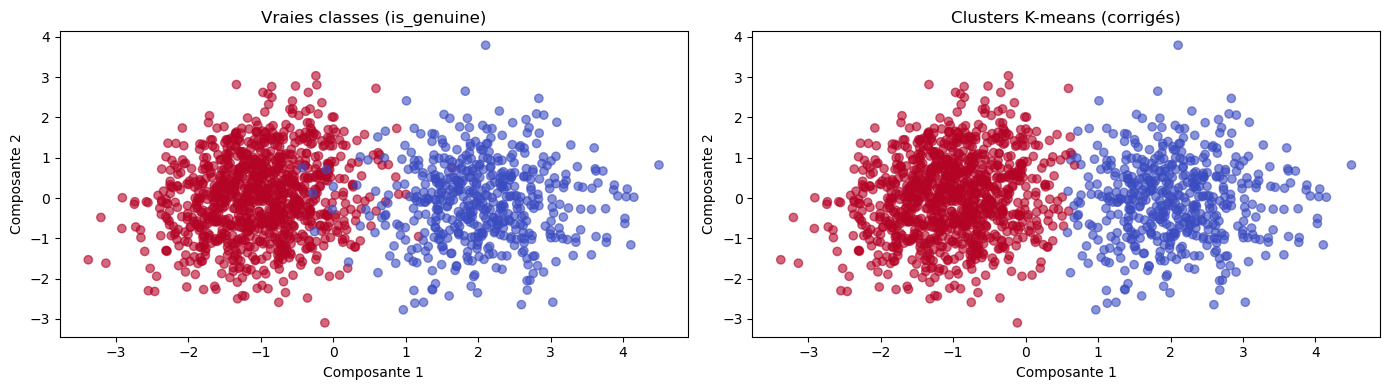

In [46]:
# Affichage des vrais groupes (is_genuine) projetés en 2D

# Correction automatique de l'inversion des clusters
if accuracy_score(y, cluster_labels) < accuracy_score(y, 1 - cluster_labels):
    cluster_labels = 1 - cluster_labels  # inverse les clusters si besoin

plt.figure(figsize=(14, 4))

# Vraies classes
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.title("Vraies classes (is_genuine)")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")

# Clusters K-means
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.6)
plt.title("Clusters K-means (corrigés)")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")

plt.tight_layout()
plt.show()


<div style="background-color:#0D47A1; padding:15px; border-radius:10px; margin-top:20px;">
  <h3 style="color:white; text-align:center; font-size:26px; margin:0;">
    5.3 – KNN (K-Nearest Neighbors)
  </h3>
</div>


In [48]:
# prédit la classe d’un billet en regardant les k billets les plus proches dans l’espace des variables géométriques

# Le modèle ne s’entraîne pas à proprement parler : il mémorise les données d'entraînement.
# Pour chaque billet à prédire, il regarde les k plus proches voisins dans X_train.
# Il attribue la classe majoritaire parmi ces voisins.

In [49]:
# Création du modèle avec k=5 (valeur par défaut raisonnable)
knn = KNeighborsClassifier(n_neighbors=5)

# Entraînement
knn.fit(X_train, y_train)

# Prédictions
y_pred_knn = knn.predict(X_test)

# Evaluation
print("Accuracy KNN :", round(accuracy_score(y_test, y_pred_knn), 3))
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_knn))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_knn))


Accuracy KNN : 0.983

Matrice de confusion :
[[105   5]
 [  0 190]]

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       110
           1       0.97      1.00      0.99       190

    accuracy                           0.98       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [50]:
# le model prédit 98,3 % des billets sur l’échantillon de test

# 105 vrais négatifs : faux billets bien identifiés
# 190 vrais positifs : vrais billets bien identifiés
# 5 faux positifs : vrais billets prédits comme faux
# 0 faux négatif : aucun faux billet échappé

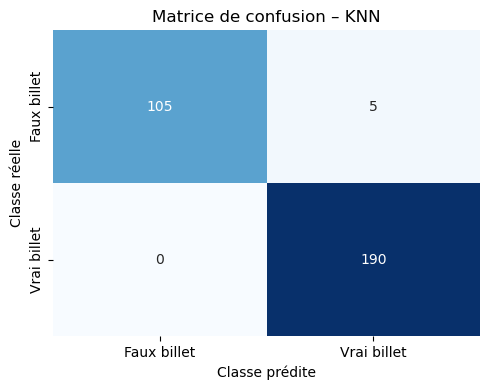

In [51]:
# Affichage graphique de la matrice de confusion KNN

# Calcul de la matrice de confusion
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Faux billet", "Vrai billet"],
            yticklabels=["Faux billet", "Vrai billet"])
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – KNN")
plt.tight_layout()
plt.show()


<div style="background-color:#1B5E20; padding:15px; border-radius:10px; margin-top:20px;">
  <h3 style="color:white; text-align:center; font-size:26px; margin:0;">
    5.4 – Random Forest
  </h3>
</div>


In [53]:
# Random Forest est un modèle d’ensemble : il construit plusieurs arbres de décision et fait voter leur décision

In [54]:
# Création et entraînement du modèle
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Prédictions sur le test set
y_pred_rf = rf.predict(X_test)

# Évaluation du modèle
print("Accuracy Random Forest :", round(accuracy_score(y_test, y_pred_rf), 3))
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_rf))


Accuracy Random Forest : 0.993

Matrice de confusion :
[[108   2]
 [  0 190]]

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       110
           1       0.99      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [55]:
# Le modèle a correctement classé 99,3 % des billets dans le jeu de test

# 108 faux billets bien classés → Vrais négatifs (le modèle a bien détecté qu’ils étaient faux)
# 190 vrais billets bien classés → Vrais positifs (le modèle a correctement reconnu qu’ils étaient vrais)
# 2 vrais billets classés comme faux → Faux positifs (le modèle a cru à tort qu’ils étaient faux)
# 0 faux billet classé comme vrai → Faux négatifs (aucun faux billet n’a échappé au modèle)

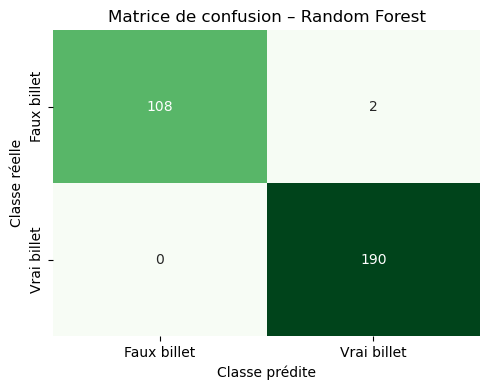

In [56]:
# Graphique de la matrice 

# Calcul de la matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=["Faux billet", "Vrai billet"],
            yticklabels=["Faux billet", "Vrai billet"])
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Random Forest")
plt.tight_layout()
plt.show()


<div style="background-color:#37474F; padding:15px; border-radius:10px; margin-top:20px;">
  <h3 style="color:white; text-align:center; font-size:26px; margin:0;">
    5.5 – SVM (Support Vector Machine)
  </h3>
</div>


In [58]:
# Le modèle de classification SVM, qui cherche à séparer les classes avec une frontière optimale, maximisant la marge entre les
# billets vrais et faux.

In [59]:

from sklearn.svm import SVC

# Création et entraînement du modèle
svm = SVC()
svm.fit(X_train, y_train)

# Prédictions
y_pred_svm = svm.predict(X_test)

# Évaluation du modèle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy SVM :", round(accuracy_score(y_test, y_pred_svm), 3))
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_svm))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_svm))


Accuracy SVM : 0.997

Matrice de confusion :
[[109   1]
 [  0 190]]

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       110
           1       0.99      1.00      1.00       190

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [60]:
# 109 faux billets bien classés → Vrais négatifs
# 190 vrais billets bien classés → Vrais positifs
# 1 vrai billet classé comme faux → Faux positif
# 0 faux billet classé comme vrai → Faux négatif 

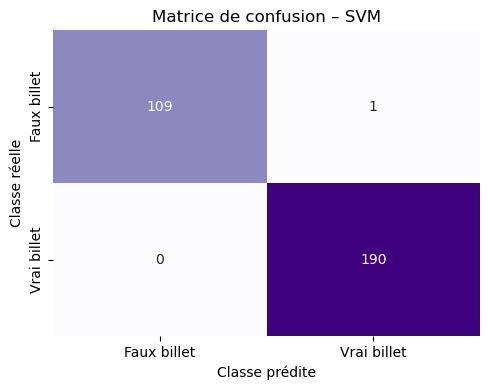

In [61]:
# Graphique 

# Calcul de la matrice de confusion pour SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=["Faux billet", "Vrai billet"],
            yticklabels=["Faux billet", "Vrai billet"])
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – SVM")
plt.tight_layout()
plt.show()


In [62]:
# Création du modèle avec les probabilités activées
svm = SVC(probability=True, random_state=42)

# Entraînement du modèle
svm.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [63]:
# Chargement du modèle et du scaler
import joblib
joblib.dump(svm, "modele_svm.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']